## Прогностична модель з використанням методу опорних векторів (SVM)

Алгоритми навчання за допомогою методу опорних векторів (SVM) буде використовуватись для побудови прогностичної моделі. SVM - один з найпопулярніших алгоритмів класифікації і має елегантний спосіб перетворення нелінійних даних, щоб можна було використовувати лінійний алгоритм для пристосування лінійної моделі до даних.

Кернелізовані методи опорних векторів є потужними моделями і добре працюють на різних наборах даних.
1. SVM допускають складні межі прийняття рішень, навіть якщо дані мають лише кілька ознак.
2. Вони добре працюють над маломірними та багатомірними даними (мало і багато ознак), але не дуже масштабують кількість вибірок.
> **Запуск SVM на даних до 10 000 зразків може працювати добре, але робота з наборами даних розміром 100 000 і більше вимагає великих обчислювальних потужностей та великих обсягів пам'яті.**

3. SVM вимагає ретельної обробки даних та налаштування параметрів. Саме тому в основному натомість використовують моделі на основі дерев, такі як "випадковий ліс" або збільшення градієнтів (для яких потрібна невелика або взагалі ніяка попередня обробка) у багатьох програмах.
4. Моделі SVM важко перевіряти; може бути важко зрозуміти, чому було зроблено конкретний прогноз, і складно пояснити модель неексперту.

#### Важливі параметри
Важливими параметрами SVM-ядер є:
* Параметр регуляризації C;
* Вибір ядра, (лінійна, функція радіальної основи (RBF) або поліном);
* Параметри ядра.

gamma та C контролюють складність моделі, причому великі значення в обох призводять до більш складної моделі. Тому налаштування для двох параметрів зазвичай сильно співвідносяться, і C, і gamma повинні коригуватись разом.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

#бібліотеки для обробки даних
import pandas as pd #обробка даних, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from scipy.stats import norm

## Контрольоване навчання.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report

# візуалізація
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.titlesize'] = 'large'


In [2]:
data = pd.read_csv('data/clean-data.csv', index_col=False)
data.drop('Unnamed: 0',axis=1, inplace=True)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
#призначення предиктору до змінної типу ndarray (matrix)
array = data.values
X = array[:,1:31] # ознаки
y = array[:,0]

#перетворення класових міток з рядкового типу (M та B) в цілочисельний
le = LabelEncoder()
y = le.fit_transform(y)

# Нормалізація даних
scaler =StandardScaler()
Xs = scaler.fit_transform(X)

### Класифікація та крос-валідація

Як вже було сказано в розділі 3 "Обробка даних" розбиття даних на тестові та навчальні набори є важливим для уникнення надмірного використання ресурсів. Це дозволяє узагальнити реальні, раніше невідомі дані. Крос-валідація продовжує цю ідею. Замість того, щоб мати один набір тестових/навчальних даних, вказуються **так звані піднабори**, щоб розділити дані на піднабори однакового розміру.

* Навчання відбувається шляхом вибору усіх піднаборів за винятком одного (зразок).
* По завершенні навчання перевіряється працездатність відповідної моделі, використовуючи зразок.

* Потім зразок використовується для навчання разом з усіма іншими піднаборами, а інший піднабір обирається як новий зразок.

* Навчання знову повторюється з рештою піднаборів і вимірюється результативність за допомогою зразка. Цей процес повторюється до тих пір, поки кожен піднабір не може бути тестовим або зразком.

* Очікувана продуктивність класифікатора, яка називається помилкою крос-валідації, є просто середнім показником помилок, обчисленим для кожного зразку.

Цей процес демонструється спочатку виконанням стандартного розбиття навчальних/тестових даних, а потім обчисленням помилки крос-валідації.

In [5]:
# 5. Розділення записів на навчальні та тестові набори
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=2, stratify=y)

# 6. Створення SVM класифікатора та його навчання на 70% даних
clf = SVC(probability=True)
clf.fit(X_train, y_train)

# 7. Аналіз точності прогнозів на 30% тестових зразків
classifier_score = clf.score(X_test, y_test)
print('\nThe classifier accuracy score is {:03.2f}\n'.format(classifier_score))


The classifier accuracy score is 0.95



Для отримання кращої міри точності прогнозування, можна послідовно розділити дані на піднабори, які будуть використовуватись для тренування та тестування:

In [6]:
# середній показник крос-валідації 3 піднаборів за допомогою оцінки SVC
n_folds = 3
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))
print('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))


The 3-fold cross-validation accuracy score for this classifier is 0.97



Наведені вище оцінки базуються на використанні всього набору ознак. Тепер буде використовуватись стратегія вибору ознак на основі кореляції, щоб оцінити ефект використання трьох ознак, які мають найкращу кореляцію з мітками класів.

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression
clf2 = make_pipeline(SelectKBest(f_regression, k=3),SVC(probability=True))

scores = cross_val_score(clf2, Xs, y, cv=3)

# середній показник крос-валідації 3 піднаборів за допомогою оцінки SVC
n_folds = 3
cv_error = np.average(cross_val_score(SVC(), Xs, y, cv=n_folds))
print('\nThe {}-fold cross-validation accuracy score for this classifier is {:.2f}\n'.format(n_folds, cv_error))


The 3-fold cross-validation accuracy score for this classifier is 0.97



In [9]:
print(scores)
avg = (100*np.mean(scores), 100*np.std(scores)/np.sqrt(scores.shape[0]))
print("Average score and uncertainty: (%.2f +- %.3f)%%"%avg)

[0.93157895 0.95263158 0.94179894]
Average score and uncertainty: (94.20 +- 0.496)%


З наведених вище результатів видно, що для побудови моделі, яка працює аналогічно моделям, заснованих на використанні всього набору ознак, потрібно лише частина ознак. Вибір ознак є важливою частиною процесу створення моделі, на яку завжди потрібно звертати особливу увагу.

### Точність моделі: ROC-крива (робоча характеристика приймача)

У статистичному моделюванні та машинному навчанні загальноприйнятим показником ефективності точності моделі для задач бінарної класифікації є площа під ROC-кривою (AUC).

Щоб зрозуміти, яку інформацію передає крива ROC, необхідно розглянути "матрицю плутанини", яка по суті є двовимірною таблицею, де модель класифікатора знаходиться на одній осі (вертикальній), а основна істина - на іншій (горизонтальній) осі, як показано нижче. Будь-яка з цих осей може приймати два значення.

Модель виводить "+" | Модель виводить "-" --- | --- | --- True positive | False negative | ** Фактичні дані: "+" ** False positive | True negative | Фактичні дані: "-"
На ROC-кривій, графік “True Positive Rate” на осі Y та “False Positive Rate” на осі X, де значення “true positive”, “false negative”, “false positive”, та “true negative” є подіями (або їх ймовірностями) як описано вище. The rates are defined according to the following.
> * True positive rate (or sensitivity)}: tpr = tp / (tp + fn)
> * False positive rate:       fpr = fp / (fp + tn)
> * True negative rate (or specificity): tnr = tn / (fp + tn)

In [10]:
# матриця плутанини допомагає візуалізувати виконання алгоритму.
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[106   1]
 [  7  57]]


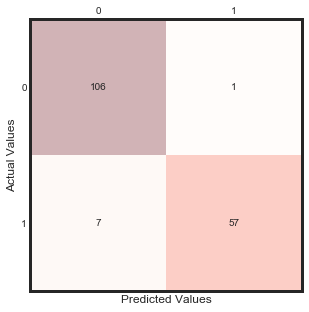

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       107
           1       0.98      0.89      0.93        64

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Image, display

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()
print(classification_report(y_test, y_pred ))

#### Результати спостережень
Є два можливі передбачувані класи: "1" і "0". Злоякісний = 1 (вказує на наявність ракових клітин) і доброякісний
= 0 (вказує на їх відсутність).

* Загалом класифікатор виконав 174 прогнозувань (тобто 174 пацієнтів було протестувано на наявність раку молочної залози).
* З цих 174 випадків класифікатор передбачив "1" 58 разів, а "0" - 113 разів.
* Насправді 64 пацієнта у вибірці мають захворювання, а 107 пацієнтів - ні.

#### Норми, обчислені за допомогою матриці хибності
1. **Accuracy**: наскільки точним є класифікатор?
    * (TP+TN)/total = (57+106)/171 = 0.95

2. **Misclassification Rate**: як часто виникають помилки?
    * (FP+FN)/total = (1+7)/171 = 0.05 (еквівалентно 1 - Точність)
    
3. **True Positive Rate**: коли насправді 1, то як часто прогнозується 1 - наявність раку?
    * * TP/actual yes = 57/64 = 0.89
    
4. **False Positive Rate**: коли насправді 0 - відсутність раку, то як часто прогнозується 1 - наявність раку?
    * FP/actual no = 1/107 = 0.01
    
5. **Specificity**: коли насправді 0, то як часто прогнозується 0 - відсутність раку?
    * TN/actual no = 106/107 = 0.99 (еквівалентно 1 - False Positive Rate)
    
6. **Precision**: коли визначається наявність раку - 1, то як часто це істина?
    * TP/predicted yes = 57/58 = 0.98
    
7. **Prevalence**: як часто умова 1 насправді трапляється у зразках?
    * actual yes/total = 64/171 = 0.34

C:\Users\Monoxrome\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


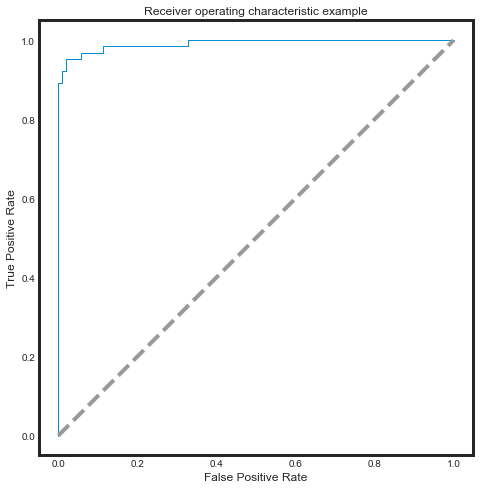

In [12]:
from sklearn.metrics import roc_curve, auc
# ROC
plt.figure(figsize=(10,8))
probas_ = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.axes().set_aspect(1)

Для точок вище діагоналі, tpr > fpr, модель говорить, що ви перебуваєте в зоні, де ви працюєте краще, ніж випадково. Наприклад, припустимо tpr = 0,99 і fpr = 0,01, Тоді ймовірність опинитися в справжній позитивній групі становить (0,99 / (0,99 + 0,01)) = 99%. Крім того, тримаючи fpr постійною, легко помітити, що чим більше вертикально ви розміщені по діагоналі, тим краща модель класифікації.